In [117]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from math import *
from heapq import nlargest
from dotenv import load_dotenv
load = load_dotenv()

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from surprise import Dataset, Reader, SVD, accuracy, dump
from surprise.model_selection import GridSearchCV, cross_validate

<div style="background-color: #99CCFF"> 
<div style = "border: 5px blue groove">
    <h1> Plan</h1> 

    

  <ul class="list-group">

  <li class="list-group-item">Etude des données</li>
  <li class="list-group-item">Controle valeurs abbérantes</li>
  <li class="list-group-item">Les modèles</li>
  <li class="list-group-item">envoie des résultats vers azure </li>

  </ul>
</div>
</div>

<div style="background-color: #3333CC"> 
<div style = "border: 5px blue groove">
<div style = " color : white">
<h2>
<b>Les articles</b>
</div>
</h2>
</div>

In [118]:
df_articles = pd.read_csv('articles_metadata.csv')
df_articles.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [119]:
df_articles.describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


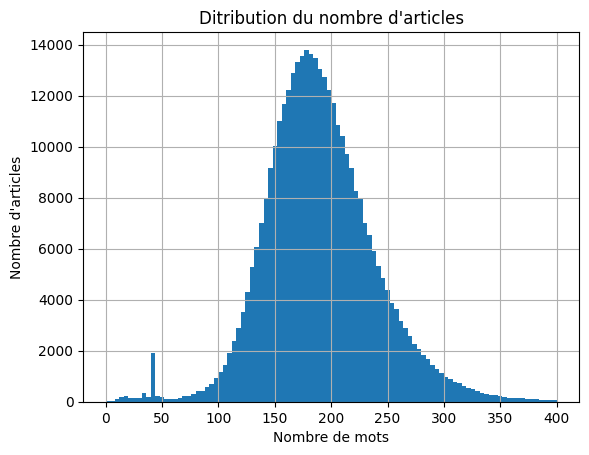

In [120]:
df_articles['words_count'].hist( bins=100, range=(0,400))
plt.title("Ditribution du nombre d'articles")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.show()

<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Le nombre de mots par article</b>
  </div>
</div>   
      La distribution des articles correspond à une loi normal
  

In [121]:
df_articles.category_id.value_counts()

281    12817
375    10005
399     9049
412     8648
431     7759
       ...  
341        1
121        1
335        1
131        1
0          1
Name: category_id, Length: 461, dtype: int64

<div style="background-color: #3333CC"> 
<div style = "border: 5px blue groove">
<div style = " color : white">
<h2>
<b>Les clicks</b>
</div>
</h2>
</div>

In [ ]:
path ='clicks'
df_clic = pd.DataFrame()
liste_click = os.listdir(path)
if '.DS_Store' in liste_click:
    liste_click.remove('.DS_Store')
for file in liste_click:
    df = pd.read_csv(path +"/" +file)
    df_clic= pd.concat([df_clic, df], axis=0)
df_clic
with open('liste_click_last.pkl', 'wb') as file:
    pickle.dump(liste_click, file)

KeyboardInterrupt: 

In [ ]:
df_clic

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2
3,294036,1507865795185844,1507865795000,2,96210,1507865849095,4,3,20,1,9,2
4,77136,1507865796257845,1507865796000,2,336245,1507866133178,4,3,2,1,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1307,15107,1507872960434128,1507872960000,4,20691,1507873325254,4,4,2,1,14,1
1308,15107,1507872960434128,1507872960000,4,327984,1507873616575,4,4,2,1,14,1
1309,15107,1507872960434128,1507872960000,4,172760,1507873646575,4,4,2,1,14,1
1310,294270,1507872968214129,1507872968000,2,96210,1507873274995,4,3,2,1,25,2


In [ ]:
df_clic = df_clic[['user_id', 'session_size', 'click_article_id']]
print(df_clic.shape)
df_clic.head()

(2988181, 3)


,user_id,session_size,click_article_id
0,93863,2,96210
1,93863,2,158094
2,294036,2,20691
3,294036,2,96210
4,77136,2,336245


In [ ]:
df_clic.describe()

,user_id,session_size,click_article_id
count,2988181,2988181,2988181
unique,322897,72,46033
top,5890,2,160974
freq,1232,1260372,37213


In [ ]:
df_users = df_clic.groupby('user_id').agg({'click_article_id':lambda x: list(x)})
df_users.head()

,click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[327984, 183176, 235840, 96663, 59758, 160474,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236444, 234318, 233688, 237452, 235745, 12096..."
4,"[336499, 271261, 48915, 44488, 195887, 195084,..."


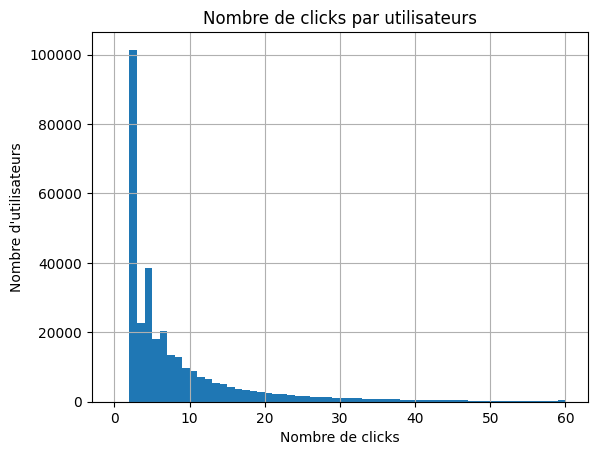

Descrition du nombre de click par utilisateur 
 count    322897.000000
mean          9.254285
std          14.946358
min           2.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        1232.000000
Name: nb, dtype: float64


In [ ]:
df_users['nb']=[len(x) for x in df_users['click_article_id'].to_list()]
df_users['nb'].hist( bins=60, range=(0,60))
plt.title("Nombre de clicks par utilisateurs")
plt.xlabel("Nombre de clicks")
plt.ylabel("Nombre d'utilisateurs")
plt.show()
print('Descrition du nombre de click par utilisateur \n',df_users['nb'].describe())

<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Supresssion des valeurs suspectes</b>
  </div>
</div>   
      Ne pouvant pas avoir d'échange avec mes collegues sur le nombre de click maximun par utilisateur

      J'utilise le Z score pour supprimer les valeurs abérantes et optimiser mon modele.

      Le Zscore indique le nombre d'écarts types entre un point de données et la moyenne.
      
      Je supprime les utilisateurs qui ont un Z score superieur à 3.


  

In [ ]:
from scipy import stats
df_users_sup = df_users[(np.abs(stats.zscore(df_users['nb']))>3)]

df_clicfinal = df_clic[df_clic.user_id.isin(list(df_users_sup.index))==False]
df_clicfinal


,user_id,session_size,click_article_id
0,93863,2,96210
1,93863,2,158094
2,294036,2,20691
3,294036,2,96210
4,77136,2,336245
...,...,...,...
1295,23438,3,70484
1296,23438,3,336245
1297,23438,3,316424
1310,294270,2,96210


<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Le fichiers final</b>
  </div>
</div>   
      Il nous reste 2,5 millions de données
  

<div style="background-color: #3333CC"> 
<div style = "border: 5px blue groove">
<div style = " color : white">
<h2>
<b>L'article embedding</b>
</div>
</h2>
</div>

In [ ]:
df_emb_article = pd.read_pickle( 'articles_embeddings.pickle')
df_emb_article= pd.DataFrame(df_emb_article,columns=["Vecteur" + str(i) for i in range(df_emb_article.shape[1])])
df_emb_article.head()

,Vecteur0,Vecteur1,Vecteur2,Vecteur3,Vecteur4,Vecteur5,Vecteur6,Vecteur7,Vecteur8,Vecteur9,...,Vecteur240,Vecteur241,Vecteur242,Vecteur243,Vecteur244,Vecteur245,Vecteur246,Vecteur247,Vecteur248,Vecteur249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [ ]:
len(df_emb_article)

364047

In [ ]:
import os
file_size = os.path.getsize(r'articles_embeddings.pickle') 
print('La taille du fichier est de :', np.round(file_size/1000000,2), 'MB')

La taille du fichier est de : 364.05 MB


In [ ]:
pca = PCA(n_components=0.95)
pca.fit(df_emb_article)
df_pca_emb= pca.transform(df_emb_article)

In [ ]:
df_pca_emb =pd.DataFrame(df_pca_emb,columns=["V_PCA" + str(i) for i in range(df_pca_emb.shape[1])])
df_pca_emb

,V_PCA0,V_PCA1,V_PCA2,V_PCA3,V_PCA4,V_PCA5,V_PCA6,V_PCA7,V_PCA8,V_PCA9,...,V_PCA42,V_PCA43,V_PCA44,V_PCA45,V_PCA46,V_PCA47,V_PCA48,V_PCA49,V_PCA50,V_PCA51
0,-2.176723,-1.317014,-1.029108,0.901979,-1.809558,2.064725,1.221681,0.024743,0.926881,0.669869,...,-0.409309,-0.724185,0.267543,0.060410,-0.089921,0.107723,0.156094,0.098129,-0.622278,-0.164891
1,-1.735195,0.490096,3.268579,0.087905,1.472996,0.932685,-1.841478,0.881783,-0.207344,-0.816851,...,-0.345709,-0.234298,0.314615,0.330383,-0.545041,0.310866,-0.207497,0.058529,-0.571052,0.082267
2,-0.912718,-2.089188,1.866138,-1.202605,2.530415,0.522006,-0.224265,-1.480076,-0.191282,-1.356860,...,-1.006058,0.249887,-0.012209,0.488583,-0.312207,-0.181390,-0.446866,0.075691,0.172025,-0.640661
3,1.096552,0.213261,4.183515,-0.649460,-0.131037,-1.126553,-1.063841,0.663032,0.348113,-1.463969,...,-0.315385,-0.435530,0.041445,0.447291,-0.178498,0.255354,-0.092548,0.543987,0.081993,-0.856991
4,0.193760,-0.263813,1.896670,-1.834368,1.270159,1.723290,-0.329046,-0.284040,-0.659601,-1.223793,...,-0.264784,-0.111498,1.088541,0.247167,-0.418174,0.391216,0.186265,0.012659,0.130875,-0.150843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,1.248752,5.252130,-0.651201,0.839724,-0.264870,-0.623172,-0.947391,0.689208,-0.902518,-0.525695,...,1.013332,0.310206,0.434558,0.190274,0.005431,0.401046,0.117741,-0.354727,-0.129969,0.309278
364043,0.575171,2.392312,-2.702693,5.805642,2.654657,1.924594,-0.671994,0.958246,-0.938802,-0.574795,...,-0.663931,1.219241,0.810828,-0.471158,0.023985,1.613441,-0.735262,-0.295038,-0.579527,-0.991394
364044,1.564094,4.053491,2.134265,1.152936,0.979943,-0.595086,0.750574,1.324067,0.679337,1.937145,...,0.686805,-0.295620,-0.074438,-0.157501,-0.020267,-0.312876,-0.446927,0.413032,0.545903,-0.250270
364045,4.866379,0.151843,-0.424527,-0.442662,-1.083566,-0.659156,1.366971,0.764171,-0.182480,-0.806428,...,0.377800,-0.177475,-0.215163,-0.371894,-0.203384,-0.191006,-0.328183,-0.055317,0.103429,-0.123677


In [ ]:
with open('pca_emb.pkl', 'wb') as file:
    pickle.dump(df_pca_emb, file)
file_size = os.path.getsize(r'pca_emb.pkl') 
print('Taille du nouveau fichier apres acp:', np.round(file_size/1000000,2), 'MB')

Taille du nouveau fichier apres acp: 75.72 MB


<div style="background-color: #3333CC"> 
<div style = "border: 5px blue groove">
<div style = " color : white">
<h2>
<b>Content-Based</b>
</div>
</h2>
</div>
</div>
  Ce système utilise les préférences d'un utilisateur pour recommander des articles similaires à ceux qu'il a déjà lus grace à la distance cosinus entre les articles

In [ ]:
def base_recom(art, clic, user_id, n=5):

    art_lu = clic[clic['user_id'] == user_id]['click_article_id'].tolist()

    if len(art_lu) == 0:
        return "L'utilisateur n'a lu aucun article"

    art_lu_emb = art.loc[art_lu]

    art = art.drop(art_lu)

    matrix = cosine_similarity(art_lu_emb, art)

    rec = []

    for i in range(n):
        coord_x = floor(np.argmax(matrix)/matrix.shape[1])
        coord_y = np.argmax(matrix)%matrix.shape[1]
        rec.append(int(art.index[coord_y]))
        matrix[coord_x][coord_y] = 0
    return rec

In [ ]:
recommandation_acp = base_recom(df_pca_emb, df_clicfinal,56677)
print(recommandation_acp)

[132064, 132914, 132021, 132022, 132868]


<div style="background-color: #3333CC"> 
<div style = "border: 5px blue groove">
<div style = " color : white">
<h2>
<b>Collaborating Filtering</b>
</div>
</h2>
</div>
</div>
  Le modèle est basé sur ce que les autres utilisateurs ont aimé, en recommandant aux utilisateurs ayant des préférences communes de lire des articles similaires.

In [ ]:
def calcul_Rating(clicks):

    article = (clicks.groupby(['user_id', "click_article_id"]).agg(user_article_size=("session_size", "sum")))
    total = (clicks.groupby(['user_id']).agg(user_total_size=("session_size", "sum")))

    ratings = article.join(total, on="user_id")

    ratings['rating'] = ratings['user_article_size'] / ratings['user_total_size']

    ratings = ratings.reset_index().drop(['user_article_size', 'user_total_size'], axis = 1).rename({'click_article_id': 'article_id'}, axis = 1)

    return ratings


In [ ]:
ratings = calcul_Rating(df_clicfinal)

ratings.sample(20)

,user_id,article_id,rating
115610,8575,270228,0.151515
1788770,166757,205832,0.022727
890876,70555,261476,0.058824
1907146,184948,300234,0.035398
272078,20635,271262,0.25
2293841,260095,59057,0.5
629795,49639,181585,0.0625
343752,26116,59758,0.055556
1622218,144933,123757,0.033333
2266860,253474,218330,0.5


<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Optimisation du modele grace à grid searchCV</b>
  </div>
</div>   

In [ ]:
reader = Reader(rating_scale=(0, 1))

data = Dataset.load_from_df(ratings.sample(frac=0.1, random_state=42), reader=reader)

param_grid = {'n_factors': [5,10,20, 50], 'n_epochs': [ 20, 50,70],
              'lr_all': [ 0.005, 0.01, 0.05], 'reg_all': [0.02, 0.04, 0.1, 0.12, 0.15]}

grid_cv = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

grid_cv.fit(data)

In [ ]:
# best RMSE score
print(grid_cv.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid_cv.best_params['rmse'])

0.11231324984031087
{'n_factors': 5, 'n_epochs': 70, 'lr_all': 0.05, 'reg_all': 0.02}


<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Entrainement du modele</b>
  </div>
</div>   

In [ ]:
data = Dataset.load_from_df(ratings, reader=reader)

train_set = data.build_full_trainset()

model = grid_cv.best_estimator['rmse']

model.fit(train_set)

In [ ]:
model.predict(5, 158536, verbose=True)

user: 5          item: 158536     r_ui = None   est = 0.19   {'was_impossible': False}


Prediction(uid=5, iid=158536, r_ui=None, est=0.19201662217043786, details={'was_impossible': False})

In [ ]:
def collab_Recom(articles, clicks, user_id, n=5):

    index = list(articles.index)

    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    for ele in articles_read:
        if ele in index:
            index.remove(ele)

    results = dict()

    for i in index:
        pred = model.predict(user_id, i)
        results[pred.iid] = pred.est
    
    return nlargest(n, results, key = results.get)

<div style="background-color: #3333CC"> 
<div style = "border: 5px blue groove">
<div style = " color : white">
<h2>
<b>Sauvegarde</b>
</div>
</h2>
</div>
</div>

<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Sur le disque local</b>
  </div>
</div>   


In [ ]:

with open('model_SVD.pickle', 'wb') as file:
    pickle.dump(model, file)

with open('articles.pickle', 'wb') as file:
    pickle.dump(df_emb_article, file)

with open('click.pickle', 'wb') as file:
    pickle.dump(df_clicfinal, file)

<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Dans azure</b>
  </div>
</div>   

In [ ]:
#from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
from azure.storage.blob import BlobClient
account_url = os.environ['ACCOUNT_URL']
creds =os.environ['CREDS']

service_client = BlobServiceClient(
    account_url=account_url,
    credential=creds
)

In [ ]:
# controle contenaire
def get_containers():
    try:
        containers = service_client.list_containers()
        print([container.name for container in containers])
    except Exception as e:
        print(e.message)
get_containers()

['azure-webjobs-hosts', 'azure-webjobs-secrets', 'p9oc', 'picklep9', 'scm-releases']


In [ ]:
def upload_to_azure(container_name, save_azure_name, chemin_fichier_name):
    blob_url = f"{account_url}/{container_name}/{save_azure_name}"
    blob_client = BlobClient.from_blob_url(blob_url=blob_url,credential=creds)
    with open(chemin_fichier_name, "rb") as blob_file:
        blob_client.upload_blob(data=blob_file,overwrite=True)
    print("Le fichier est à été sauvegardé sous azure avec le mom : ",save_azure_name)

In [ ]:
upload_to_azure('picklep9','test.pickle','click.pickle')

In [ ]:
test_cf = collab_Recom(df_emb_article,df_clic, 99, 5)
print(test_cf)

[25058, 73431, 145117, 106982, 162888]


<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Mise à jour du modele</b>
  </div>
</div>   

In [ ]:
# mise à jour click
def mise_jour_click(): 
    list_initi = pd.read_pickle('liste_click_last.pkl')
    path ='clicks'
    df_clic = pd.read_pickle('click.pickle')
    liste_click = os.listdir(path)
    with open('liste_click_last.pkl', 'wb') as file:
        pickle.dump(liste_click, file)
    liste_click.remove(list_initi)
    if '.DS_Store' in liste_click:
        liste_click.remove('.DS_Store')
    for file in liste_click:
        df = pd.read_csv(path +"/" +file)
        df_clic= pd.concat([df_clic, df], axis=0)
    return df_clic

<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Mise à jour du modele</b>
  </div>
</div>   

In [ ]:
# mise à jour modele
def mise_jour_modele():
    df_clic = mise_jour_click
    ratings = calcul_Rating(df_clic)
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(ratings.sample(frac=0.1, random_state=42), reader=reader)
    param_grid = {'n_factors': [5,10,20, 50], 'n_epochs': [ 20, 50,70],'lr_all': [ 0.005, 0.01, 0.05], 'reg_all': [0.02, 0.04, 0.1, 0.12, 0.15]}
    grid_cv = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    grid_cv.fit(data)
    data = Dataset.load_from_df(ratings, reader=reader)
    train_set = data.build_full_trainset()
    model = grid_cv.best_estimator['rmse']
    model.fit(train_set)
    return model

<div style="background-color: #7ea1ad"> 
  <div style = "border: 5px black groove">
      <b>Eude nombre de click par article</b>
  </div>
</div>   

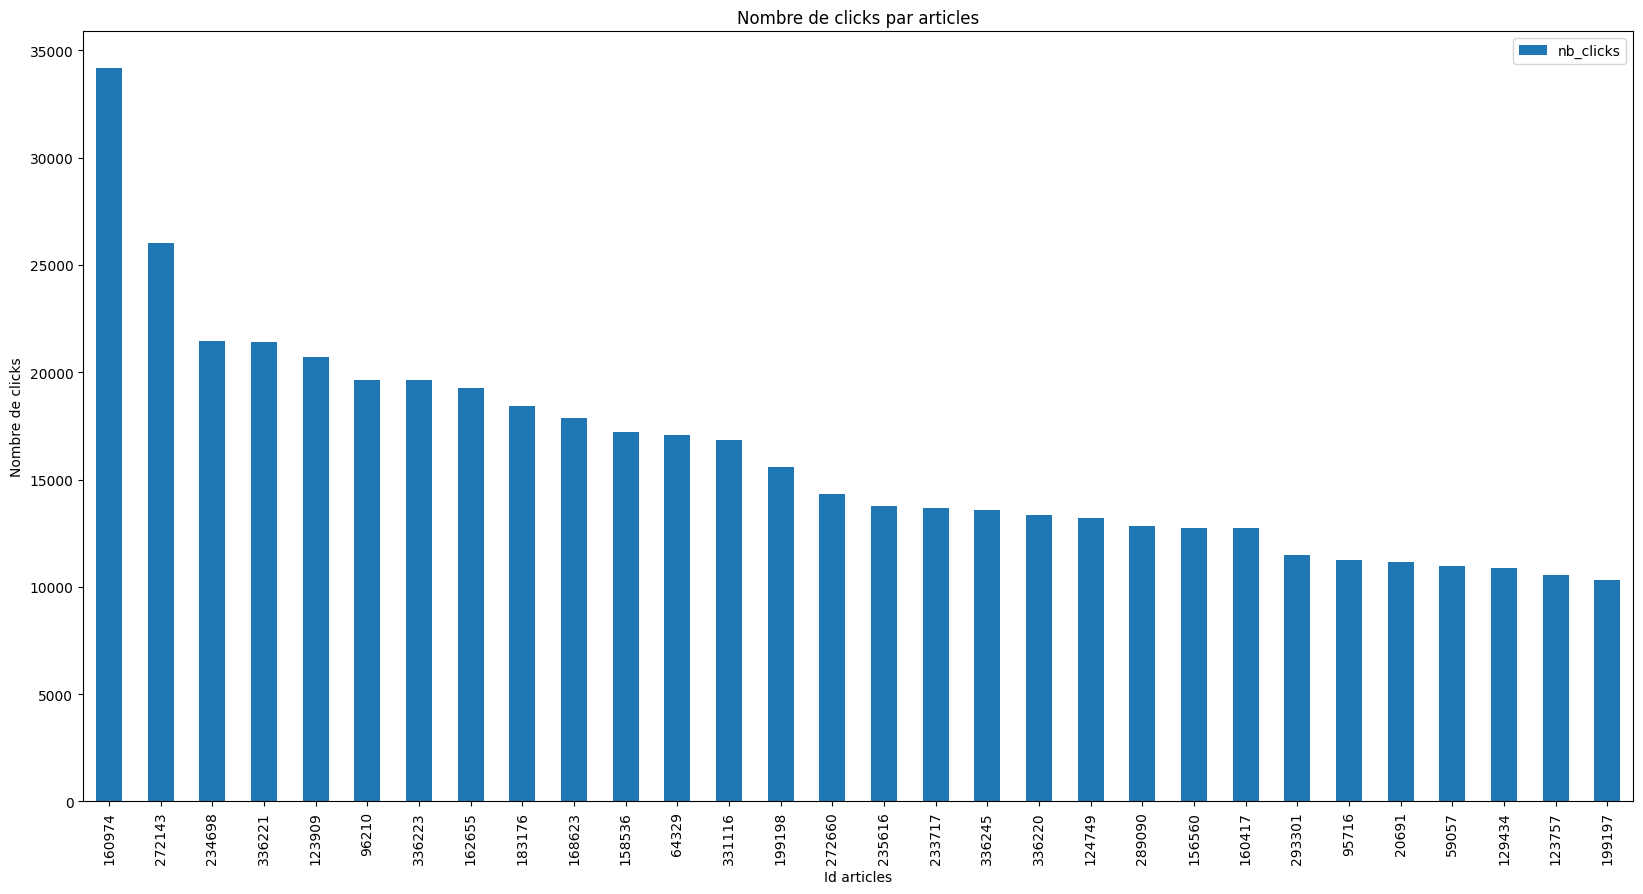

In [ ]:
nb_clicks = df_clicfinal.groupby('click_article_id').agg({'user_id': 'count'}).rename(columns={'user_id': 'nb_clicks'}).reset_index()
nb_clicks = nb_clicks.sort_values(by='nb_clicks', ascending=False)
nb_clicks = nb_clicks.head(30)
nb_clicks.plot.bar(x='click_article_id', y='nb_clicks', figsize=(20, 10))
plt.title("Nombre de clicks par articles")
plt.ylabel("Nombre de clicks")
plt.xlabel("Id articles")
plt.show()

<div style="background-color: #3333CC"> 
<div style = "border: 5px blue groove">
<div style = " color : white">
<h2>
<b>Modèle hybride</b>
</div>
</h2>
</div>
</div>

In [ ]:
def model_hybride(emb,clic,user):
    coll = collab_Recom(emb ,clic, user, 1000)
    base = base_recom(emb,clic,user, 1000)
    df_hyb_coll = pd.DataFrame(coll, columns=['colab'])
    df_hyb_coll['point_coll']=df_hyb_coll.index+1
    df_hyb_base = pd.DataFrame(base, columns=['colab'])
    df_hyb_base['point_base']=df_hyb_base.index+1
    df_hyb = pd.merge(df_hyb_base,df_hyb_coll,on='colab',how='outer')
    df_hyb = df_hyb.fillna(1001)
    df_hyb['point']= df_hyb['point_base']+df_hyb['point_coll']
    recomm = df_hyb.sort_values('point').head(5)
    recom_list = recomm['colab'].to_list()
    Recom_final = [base[0], coll[0] ]
    Recom_final.extend(base[0:3])
    print('Recommandation hydride :',recom_list)
    print('Recommandation Collaborative filtering',coll[0:5])
    print('Recommandation content base' , base[0:5])
    print('Recommandation Mixte' , Recom_final)
    return recomm

In [ ]:
model_hybride(df_emb_article,df_clic, 5)


Recommandation hydride : [279662, 202320, 202817, 124693, 212734]
Recommandation Collaborative filtering [25058, 73431, 145117, 106982, 162888]
Recommandation content base [157015, 284603, 62627, 62630, 224354]
Recommandation Mixte [157015, 25058, 157015, 284603, 62627]


,colab,point_base,point_coll,point
102,279662,86.0,282.0,368.0
388,202320,352.0,248.0,600.0
447,202817,414.0,231.0,645.0
610,124693,575.0,220.0,795.0
747,212734,716.0,247.0,963.0
